# Statistik-Projekt HS25 – Notebook 09: Hypothesentest III (Wochentag)
## Forschungsfrage
Ist der öffentliche Verkehr am Wochenende pünktlicher als an Werktagen?
Wir vermuten, dass aufgrund des geringeren Pendlerverkehrs und weniger Taktverdichtung am Wochenende weniger Verspätungen auftreten.

## Hypothesen
* $H_0$: Die Verspätungen an Werktagen und Wochenenden sind gleich verteilt. ($\mu_{Werktag} = \mu_{Wochenende}$)
* $H_1$: Es gibt einen signifikanten Unterschied zwischen Werktagen und Wochenenden.

## Methode
Wir vergleichen genau **zwei unabhängige Gruppen** ("Werktag" vs. "Wochenende").
Da die Daten nicht normalverteilt sind, verwenden wir den **Mann-Whitney-U-Test** (auch Wilcoxon-Rangsummentest genannt). Dies ist die nicht-parametrische Alternative zum t-Test.

## Input
* Datei: `../data/processed/istdata_clean_extended.parquet`

In [1]:
import polars as pl
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1. Konfiguration
INPUT_PATH = "../../data/processed/istdata_clean_extended.parquet"

# 2. Daten laden
print(f"Lade Daten aus {INPUT_PATH}...")
df = pl.read_parquet(INPUT_PATH)

# Sample ziehen (200.000 Zeilen reichen für sehr hohe Power)
df_sample = df.sample(n=200000, seed=42).to_pandas()
print(f"Arbeite mit Stichprobe: {len(df_sample)} Zeilen.")

# Check: Haben wir genug Daten für beide Gruppen?
print("\nAnzahl Fahrten:")
print(df_sample["is_weekend"].value_counts().rename({True: "Wochenende", False: "Werktag"}))

Lade Daten aus ../../data/processed/istdata_clean_extended.parquet...
Arbeite mit Stichprobe: 200000 Zeilen.

Anzahl Fahrten:
is_weekend
Werktag       149744
Wochenende     50256
Name: count, dtype: int64


In [2]:
# Gruppen trennen
# Wir nehmen die Variable 'is_weekend' (True/False), die wir in N01 erstellt haben
werktag = df_sample[df_sample["is_weekend"] == False]["arr_delay_min"].values
wochenende = df_sample[df_sample["is_weekend"] == True]["arr_delay_min"].values

# Test durchführen (Zweiseitig: Wir testen auf *irgendeinen* Unterschied)
stat, p_value = mannwhitneyu(werktag, wochenende, alternative='two-sided')

print(f"--- Mann-Whitney-U-Test ---")
print(f"U-Statistik: {stat}")
print(f"p-Wert:      {p_value:.4e}")

alpha = 0.05
if p_value < alpha:
    print("\nERGEBNIS: H0 abgelehnt! Es gibt einen signifikanten Unterschied zwischen Werktag und Wochenende.")
else:
    print("\nERGEBNIS: H0 angenommen. Kein signifikanter Unterschied nachweisbar.")

# Richtung des Effekts prüfen (Wer ist besser?)
# Dazu schauen wir uns die Mediane an
med_werktag = np.median(werktag)
med_wochenende = np.median(wochenende)

print(f"\n--- Vergleich der Mediane ---")
print(f"Median Werktag:    {med_werktag:.2f} min")
print(f"Median Wochenende: {med_wochenende:.2f} min")
print(f"Differenz:         {med_werktag - med_wochenende:.2f} min")

--- Mann-Whitney-U-Test ---
U-Statistik: 4170717659.5
p-Wert:      1.6124e-290

ERGEBNIS: H0 abgelehnt! Es gibt einen signifikanten Unterschied zwischen Werktag und Wochenende.

--- Vergleich der Mediane ---
Median Werktag:    0.67 min
Median Wochenende: 0.47 min
Differenz:         0.20 min


In [3]:
# Formel für Rank-Biserial Correlation aus der U-Statistik
# r = 1 - (2 * U) / (n1 * n2)
n1 = len(werktag)
n2 = len(wochenende)

r = 1 - (2 * stat) / (n1 * n2)

print(f"--- Effektstärke ---")
print(f"Rank-Biserial Correlation (r): {r:.4f}")
print("(Interpretation: |r| < 0.1 = vernachlässigbar, 0.1-0.3 = klein, 0.3-0.5 = mittel, >0.5 = gross)")

if abs(r) < 0.1:
    print("-> Der statistische Unterschied ist zwar signifikant, aber der praktische Effekt ist sehr klein.")
    print("-> Das bedeutet: Ja, das Wochenende ist anders, aber man merkt es als Passagier kaum.")

--- Effektstärke ---
Rank-Biserial Correlation (r): -0.1084
(Interpretation: |r| < 0.1 = vernachlässigbar, 0.1-0.3 = klein, 0.3-0.5 = mittel, >0.5 = gross)


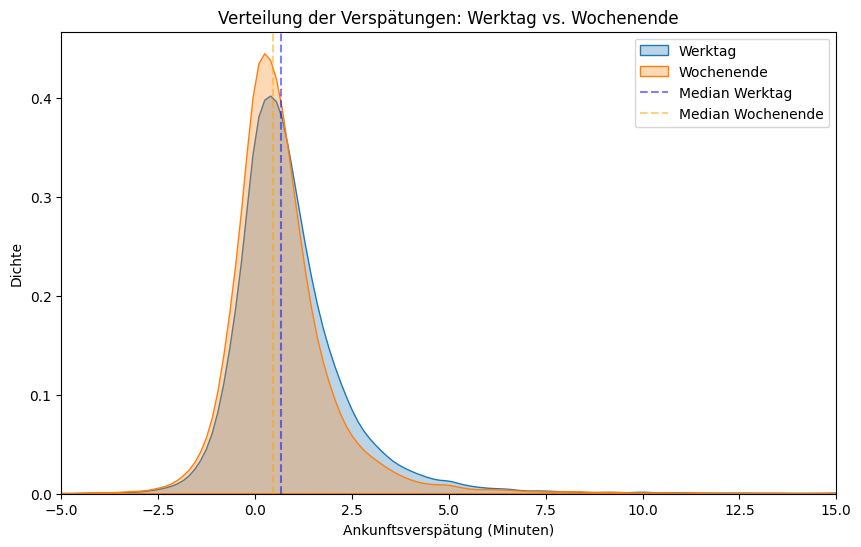

In [4]:
plt.figure(figsize=(10, 6))

# Wir beschränken den Plot auf -5 bis 15 Minuten für bessere Lesbarkeit
sns.kdeplot(werktag, label="Werktag", fill=True, alpha=0.3, clip=(-10, 20))
sns.kdeplot(wochenende, label="Wochenende", fill=True, alpha=0.3, clip=(-10, 20))

plt.axvline(np.median(werktag), color='blue', linestyle='--', alpha=0.5, label='Median Werktag')
plt.axvline(np.median(wochenende), color='orange', linestyle='--', alpha=0.5, label='Median Wochenende')

plt.title("Verteilung der Verspätungen: Werktag vs. Wochenende")
plt.xlabel("Ankunftsverspätung (Minuten)")
plt.ylabel("Dichte")
plt.legend()
plt.xlim(-5, 15)

plt.show()